I followed https://dataespresso.com/en/2019/02/07/fitbit-json-to-csv/
to make sense of my csv data.

In [1]:
import pandas as pd
import pandas_profiling
import glob
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
import pickle
#Disables annoying warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#libaries
import numpy as np
import pandas as pd

import os
import tarfile
import urllib
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV,cross_val_predict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse


%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
## Creating lists of all the respective files in the directory
heart_rate_file_list = glob.glob('GeorgeAshley/user-site-export/heart_rate-*')
steps_file_list = glob.glob('GeorgeAshley/user-site-export/steps-*')
altitude_file_list = glob.glob('GeorgeAshley/user-site-export/altitude-*')
calories_file_list = glob.glob('GeorgeAshley/user-site-export/calories-*')
sleep_file_list = glob.glob('GeorgeAshley/user-site-export/sleep-*')

In [3]:
display(sleep_file_list)

['GeorgeAshley/user-site-export/sleep-2018-12-06.json',
 'GeorgeAshley/user-site-export/sleep-2019-01-05.json',
 'GeorgeAshley/user-site-export/sleep-2019-03-06.json',
 'GeorgeAshley/user-site-export/sleep-2019-02-04.json',
 'GeorgeAshley/user-site-export/sleep-2018-11-06.json',
 'GeorgeAshley/user-site-export/sleep-2019-04-05.json',
 'GeorgeAshley/user-site-export/sleep-2018-10-07.json']

In [4]:
def get_json_to_df(file_list = []):
    df_list = []
    for json_file in file_list:
        df_list.append(pd.read_json(json_file))
    df = pd.concat(df_list)
    return df

def make_new_df_value(x='',column_name=''):
    try:
        x = x[column_name]
    except Exception as e:
        print(e)
        x = 0.0
    return x
    

def merge_dataframes(df1,df2):
    merged = pd.merge(df1, df2,how='outer', on='dateTime')
    return merged

In [5]:
heart_rate_df = get_json_to_df(file_list = heart_rate_file_list).reset_index()
## Heart rate contains a sub json that are explicitly converted into column
heart_rate_df['bpm'] = heart_rate_df['value'].transform(lambda x: make_new_df_value(x,'bpm'))
heart_rate_df['confidence'] = heart_rate_df['value'].transform(lambda x: make_new_df_value(x,'confidence'))
heart_rate_df = heart_rate_df.drop(['value','index'],axis=1)

steps_df = get_json_to_df(file_list = steps_file_list).rename(columns={'value': 'steps'})
altitude_df = get_json_to_df(file_list = altitude_file_list).rename(columns={'value': 'altitude'})
calories_df = get_json_to_df(file_list = calories_file_list).rename(columns={'value': 'calories'})

In [6]:
sleep_df = get_json_to_df(file_list = sleep_file_list).rename(columns={'timeInBed': 'timebed','minutesAsleep': 'minsleep'})

In [3]:
sleep_df

In [25]:
#Get relevant columns
col_list = ["dateOfSleep","duration","minsleep","timebed"]
sleep_df = sleep_df[col_list]

In [169]:
sdic = {}
for x in sleep_df.iterrows():
    sdic[x[1][0]] = (x[1][1],x[1][2],x[1][3])

In [37]:
merged = merge_dataframes(heart_rate_df,steps_df)
#merged = merge_dataframes(merged,altitude_df) #Altitude is useless
merged = merge_dataframes(merged,calories_df)

In [39]:
merged = merged.sort_values(by=['dateTime'])

In [105]:
#Function to replace the new times in sleep with the dictionary values.
def sleepfun(row, i):
    time = str(row.dateTime.year) + "-" + str(row.dateTime.month) + "-" + str(row.dateTime.day).zfill(2)
    if str(time) in sdic:
        if i == "duration":
            return int(sdic[time][0])
        if i == "minsleep":
            return int(sdic[time][1])
        if i == "timebed":
            return int(sdic[time][2])

In [98]:
temp = merged[3000:3010]

In [104]:
temp #Lot of missing data due to different time-step scales

,dateTime,bpm,confidence,steps,calories,dateOfSleep,duration,minsleep,timebed
2108175,2018-10-09 00:23:22,80.0,2.0,NaN,NaN,2018-10-09 00:23:22,32040000,2018-10-09 00:23:22,2018-10-09 00:23:22
2108176,2018-10-09 00:23:27,83.0,2.0,NaN,NaN,2018-10-09 00:23:27,32040000,2018-10-09 00:23:27,2018-10-09 00:23:27
2108177,2018-10-09 00:23:37,81.0,3.0,NaN,NaN,2018-10-09 00:23:37,32040000,2018-10-09 00:23:37,2018-10-09 00:23:37
2108178,2018-10-09 00:23:42,79.0,3.0,NaN,NaN,2018-10-09 00:23:42,32040000,2018-10-09 00:23:42,2018-10-09 00:23:42
2108179,2018-10-09 00:23:47,79.0,2.0,NaN,NaN,2018-10-09 00:23:47,32040000,2018-10-09 00:23:47,2018-10-09 00:23:47
2108180,2018-10-09 00:23:52,80.0,2.0,NaN,NaN,2018-10-09 00:23:52,32040000,2018-10-09 00:23:52,2018-10-09 00:23:52
2435790,2018-10-09 00:24:00,NaN,NaN,NaN,1.11,2018-10-09 00:24:00,32040000,2018-10-09 00:24:00,2018-10-09 00:24:00
2108181,2018-10-09 00:24:07,80.0,2.0,NaN,NaN,2018-10-09 00:24:07,32040000,2018-10-09 00:24:07,2018-10-09 00:24:07
2108182,2018-10-09 00:24:12,81.0,2.0,NaN,NaN,2018-10-09 00:24:12,32040000,2018-10-09 00:24:12,2018-10-09 00:24:12
2108183,2018-10-09 00:24:17,79.0,3.0,NaN,NaN,2018-10-09 00:24:17,32040000,2018-10-09 00:24:17,2018-10-09 00:24:17


In [100]:
sdic["2018-10-09"]

(32040000, 459, 534)

In [106]:
merged['duration'] = merged.apply (lambda row: sleepfun(row,"duration"), axis=1)
merged['minsleep'] = merged.apply (lambda row: sleepfun(row,"minsleep"), axis=1)
merged['timebed'] = merged.apply (lambda row: sleepfun(row,"timebed"), axis=1)

In [113]:
merged.duration[3000:3010]

2108175    32040000.0
2108176    32040000.0
2108177    32040000.0
2108178    32040000.0
2108179    32040000.0
2108180    32040000.0
2435790    32040000.0
2108181    32040000.0
2108182    32040000.0
2108183    32040000.0
Name: duration, dtype: float64

In [114]:
#Skip the first values where bpm isn't registered.
merged = merged[3010:]
merged[:10]

,dateTime,bpm,confidence,steps,calories,dateOfSleep,duration,minsleep,timebed
2108184,2018-10-09 00:24:22,79.0,2.0,NaN,NaN,2018-10-09 00:24:22,32040000.0,459.0,534.0
2108185,2018-10-09 00:24:32,80.0,2.0,NaN,NaN,2018-10-09 00:24:32,32040000.0,459.0,534.0
2108186,2018-10-09 00:24:37,83.0,3.0,NaN,NaN,2018-10-09 00:24:37,32040000.0,459.0,534.0
2108187,2018-10-09 00:24:42,82.0,3.0,NaN,NaN,2018-10-09 00:24:42,32040000.0,459.0,534.0
2108188,2018-10-09 00:24:47,78.0,3.0,NaN,NaN,2018-10-09 00:24:47,32040000.0,459.0,534.0
2108189,2018-10-09 00:24:57,79.0,2.0,NaN,NaN,2018-10-09 00:24:57,32040000.0,459.0,534.0
2435791,2018-10-09 00:25:00,NaN,NaN,NaN,3.33,2018-10-09 00:25:00,32040000.0,459.0,534.0
2108190,2018-10-09 00:25:02,81.0,3.0,NaN,NaN,2018-10-09 00:25:02,32040000.0,459.0,534.0
2108191,2018-10-09 00:25:07,82.0,2.0,NaN,NaN,2018-10-09 00:25:07,32040000.0,459.0,534.0
2108192,2018-10-09 00:25:12,83.0,3.0,NaN,NaN,2018-10-09 00:25:12,32040000.0,459.0,534.0


In [115]:
#Fill nan values
#There is a much better way to interpolate these values, this gives result I was looking for though
merged.bpm = merged.bpm.interpolate("linear",limit=20)
merged.bpm = merged.bpm.interpolate("linear",limit=100)
merged.bpm = merged.bpm.interpolate("linear",limit=300)

/home/ashleygw/.local/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [116]:
merged.steps = merged.steps.interpolate("linear",limit=20)
merged.steps = merged.steps.interpolate("linear",limit=100)
merged.steps = merged.steps.interpolate("linear",limit=1000)

In [117]:
merged.calories = merged.calories.interpolate("linear",limit=2000)
merged.calories = merged.calories.interpolate("linear",limit=10000)

In [118]:
merged.confidence = merged.confidence.interpolate("linear",limit=20)
merged.confidence = merged.confidence.interpolate("linear",limit=200)
merged.confidence = merged.confidence.interpolate("linear",limit=1000)

In [119]:
#Adding new feature of the days and months of the week
merged["weekday"] = pd.to_datetime(merged['dateTime']).dt.weekday_name
merged["month"] = pd.to_datetime(merged['dateTime']).dt.month

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [120]:
merged[:10]

,dateTime,bpm,confidence,steps,calories,dateOfSleep,duration,minsleep,timebed,weekday,month
2108184,2018-10-09 00:24:22,79.0,2.0,NaN,NaN,2018-10-09 00:24:22,32040000.0,459.0,534.0,Tuesday,10
2108185,2018-10-09 00:24:32,80.0,2.0,NaN,NaN,2018-10-09 00:24:32,32040000.0,459.0,534.0,Tuesday,10
2108186,2018-10-09 00:24:37,83.0,3.0,NaN,NaN,2018-10-09 00:24:37,32040000.0,459.0,534.0,Tuesday,10
2108187,2018-10-09 00:24:42,82.0,3.0,NaN,NaN,2018-10-09 00:24:42,32040000.0,459.0,534.0,Tuesday,10
2108188,2018-10-09 00:24:47,78.0,3.0,NaN,NaN,2018-10-09 00:24:47,32040000.0,459.0,534.0,Tuesday,10
2108189,2018-10-09 00:24:57,79.0,2.0,NaN,NaN,2018-10-09 00:24:57,32040000.0,459.0,534.0,Tuesday,10
2435791,2018-10-09 00:25:00,80.0,2.5,NaN,3.330,2018-10-09 00:25:00,32040000.0,459.0,534.0,Tuesday,10
2108190,2018-10-09 00:25:02,81.0,3.0,NaN,3.145,2018-10-09 00:25:02,32040000.0,459.0,534.0,Tuesday,10
2108191,2018-10-09 00:25:07,82.0,2.0,NaN,2.960,2018-10-09 00:25:07,32040000.0,459.0,534.0,Tuesday,10
2108192,2018-10-09 00:25:12,83.0,3.0,NaN,2.775,2018-10-09 00:25:12,32040000.0,459.0,534.0,Tuesday,10


In [121]:
#Removes remaining NaN entries by replacing with median value. 
merged = merged.fillna(merged.median())

In [ ]:
#Initial visualizations showed weekdays were not helpful.
#Dropping them
merged.loc[merged['weekday'] == "Monday", 'bpm'].describe()
merged.loc[merged['weekday'] == "Tuesday", 'bpm'].describe()
merged.loc[merged['weekday'] == "Wednesday", 'bpm'].describe()
merged.loc[merged['weekday'] == "Thursday", 'bpm'].describe()
merged.loc[merged['weekday'] == "Friday", 'bpm'].describe()
merged.loc[merged['weekday'] == "Saturday", 'bpm'].describe()
merged.loc[merged['weekday'] == "Sunday", 'bpm'].describe()

In [52]:
def timeFunc(row):
    time = row.dateTime - 
    return time

In [53]:
merged['dateTime'] = merged.apply (lambda row: timeFunc(row), axis=1)

In [54]:
merged.dateTime[0]

8

In [48]:
#Save the database so I don't have to do this every time
pickle.dump(merged, open("save.p", "wb" ) )

In [2]:
#Reloading the DB
merged = pickle.load( open("save.p", "rb" ) )

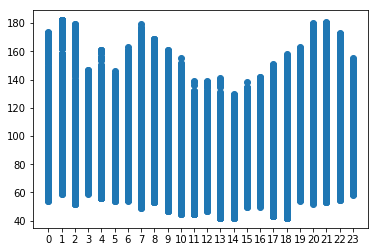

In [4]:
#Plotting shows a reasonable correlation with the time of day
plt.scatter(merged["dateTime"],merged["bpm"])

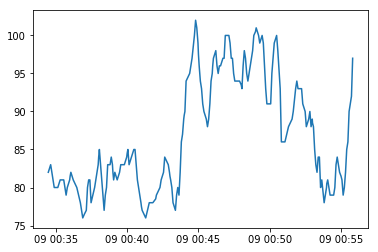

In [6]:
#We can zoom in on a few days though, and get an idea of what
#a typical few days looks like. 
plt.plot(merged["dateTime"][100:300],merged["bpm"][100:300])

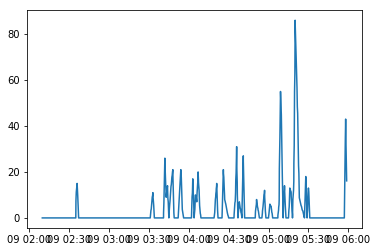

In [7]:
#Lets plot the calories and steps too
plt.plot(merged["dateTime"][1000:3000],merged["steps"][1000:3000])

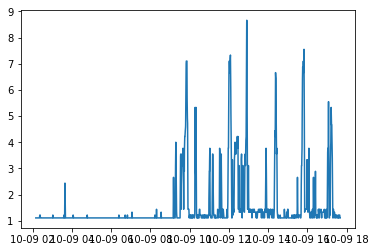

In [8]:
plt.plot(merged["dateTime"][1000:9000],merged["calories"][1000:9000])

In [5]:
corr = merged.corr()
corr.style.background_gradient()

,bpm,confidence,steps,calories,duration,minsleep,timebed,month
bpm,1,-0.506108,0.462985,-0.0875123,0.000341358,0.000633391,0.000341358,-0.0270727
confidence,-0.506108,1,-0.301741,0.0917094,0.0234748,0.0227166,0.0234748,0.0485523
steps,0.462985,-0.301741,1,-0.0253081,-0.0197613,-0.0194892,-0.0197613,-0.013226
calories,-0.0875123,0.0917094,-0.0253081,1,-0.00103667,0.000771562,-0.00103667,0.00677831
duration,0.000341358,0.0234748,-0.0197613,-0.00103667,1,0.978584,1,0.0228563
minsleep,0.000633391,0.0227166,-0.0194892,0.000771562,0.978584,1,0.978584,0.0299476
timebed,0.000341358,0.0234748,-0.0197613,-0.00103667,1,0.978584,1,0.0228563
month,-0.0270727,0.0485523,-0.013226,0.00677831,0.0228563,0.0299476,0.0228563,1


In [56]:
print(corr["bpm"].sort_values(ascending=False))

bpm           1.000000
steps         0.462985
dateTime      0.003133
minsleep      0.000633
timebed       0.000341
duration      0.000341
month        -0.027073
calories     -0.087512
confidence   -0.506108
Name: bpm, dtype: float64


In [ ]:
#Looks like steps and confidence have significant correlations with the bmp

In [57]:
#Splitting data into training and testing sets.
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(merged, test_size=0.2, random_state=42)

In [58]:
#Drop our target data
dl = train_set["bpm"].copy()
d = train_set.drop("bpm", axis=1)

In [165]:
tl = test_set["bpm"].copy()
t = test_set.drop("bpm",axis=1)

In [59]:
#Beginning data modification for Machine learning
#Using pipelines to turn month and day of week into categorical data. Scaling numerical data for better training.
cat_attribs = ['month','dateTime']
num_attribs = ["confidence","steps","calories","duration","minsleep"]

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [60]:
prepared_data = full_pipeline.fit_transform(d)

In [166]:
ptest = full_pipeline.fit_transform(t)

In [62]:
def display_scores(scores):
    # print("Scores:", scores)
    print("Mean:", scores.mean())
    print("STdev:", scores.std())

In [37]:
#Random Forest
forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, prepared_data, dl, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Mean: 10.362101283338491
STdev: 0.004490556949845015


In [2]:
#This builds a dictionary with our distribution of values
cv_scores = cross_val_predict(forest_reg,prepared_data,dl, cv=2,n_jobs=2)
unique, counts = np.unique(cv_scores, return_counts=True)
ddd = dict(zip(unique, counts))

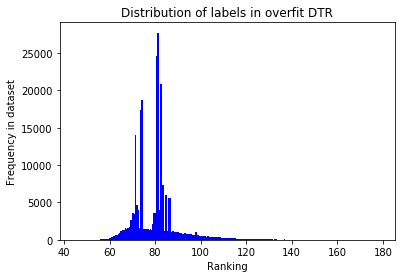

In [40]:
#Gives us an idea for what our data looks like 
plt.bar(list(ddd), ddd.values(), color='b')
plt.title("Distribution of labels in overfit DTR")
plt.xlabel("Ranking")
plt.ylabel("Frequency in dataset")
plt.show()

In [161]:
#Moving on to using a dense neural network for predictions.
dll = np.array(dl)

In [18]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed) 

In [213]:
num_epochs = int(5e5)

batch_size = 1

n_inputs =36
n_outputs = 1
num_nodes_l1 = 128
num_nodes_l2 = 256
num_nodes_l3 = 128
reset_graph()

In [214]:
xs = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
ys = tf.placeholder(tf.float32, shape=(None), name="y") 

In [215]:
hidden1 = tf.layers.dense(xs, num_nodes_l1, name="hidden1",
                              activation=tf.nn.relu)
hidden2 = tf.layers.dense(hidden1, num_nodes_l2, name="hidden2",
                              activation=tf.nn.relu)
hidden3 = tf.layers.dense(hidden2, num_nodes_l3, name="hidden3",
                              activation=tf.nn.relu)
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

In [216]:
cost = tf.reduce_mean(tf.square(outputs-ys))
train = tf.train.AdamOptimizer(0.001).minimize(cost)

In [217]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(num_epochs):
        if not(i%(20000)):
            print(i)
        # select random subsets of data to train on (aka batches)
        rnd_idx = np.random.randint(len(dll))
        X_batch = np.array([prepared_data[rnd_idx]])
        y_batch = dll[rnd_idx]
        sess.run(train, feed_dict={xs: X_batch, ys: y_batch})
        
    # generate predicted output values for y
    pred_ys = sess.run(outputs, feed_dict={xs:ptest})

0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
420000
440000
460000
480000


Text(0.5, 1.0, 'Test Values')

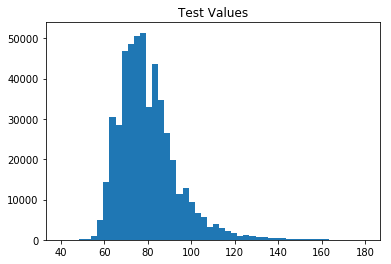

In [211]:
plt.hist(tl,bins = 50,range = (40,180),histtype="stepfilled",label="Test output")
plt.title("Test Values")

Text(0.5, 1.0, 'Predicted Output')

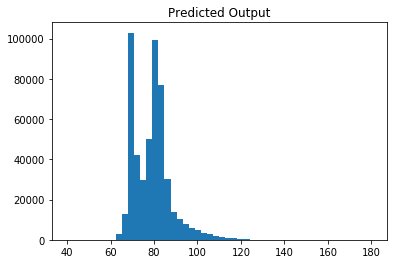

In [212]:
plt.hist(pred_ys,bins = 50,range = (40,180),histtype="stepfilled",label="Predicted output")
plt.title("Predicted Output")

In [218]:
err = mean_squared_error(tl, pred_ys,multioutput='raw_values')

In [219]:
err

array([94.24086932])

Text(0.5, 1.0, 'Test Values')

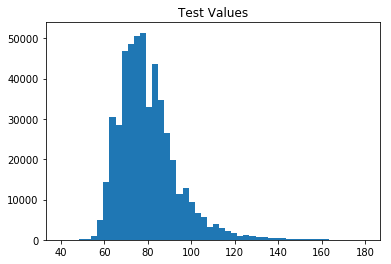

In [220]:
plt.hist(tl,bins = 50,range = (40,180),histtype="stepfilled",label="Test output")
plt.title("Test Values")

Text(0.5, 1.0, 'Predicted Output Larger Size')

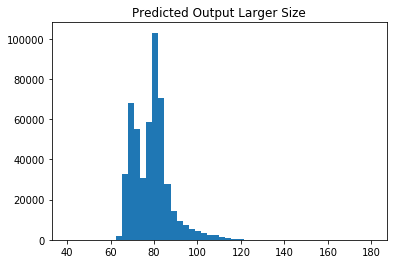

In [222]:
#This graph was created using a larger DNN. We see similar results to the smaller network, and the decision tree. 
plt.hist(pred_ys,bins = 50,range = (40,180),histtype="stepfilled",label="Predicted output")
plt.title("Predicted Output Larger Size")

In [6]:
#Time to try using a sequential model.
#Just the bpm data
bpm = merged.bpm

In [29]:
bpm = np.array(bpm)

In [53]:
bpmtrain = bpm[:int(len(bpm)*.8)]
bpmtest = bpm[int(len(bpm)*.8):]

In [173]:
def time_series(t):
    return bpm.take(t)

def next_batch(batch_size, n_steps):
    t0 = np.round(np.random.rand(batch_size, 1)*len(bpmtrain)) #* (t_max - t_min - n_steps * resolution)
    t0 = t0.astype(int)
    Ts = t0 + np.arange(0, n_steps)# * resolution
    ys = time_series(Ts)
    return Ts.reshape(batch_size,n_steps,1), ys.reshape(batch_size,n_steps,1)

In [159]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

I'll be taking 20 timesteps of bpm readings as an input to the network. At each epoch, 30 selections of these timesteps are taken and used as training data. 

In [160]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [161]:
n_outputs = 1
learning_rate = 0.001

In [162]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [163]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [185]:
n_iterations = 650000
batch_size = 30

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 10000 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    t_instance,actual_t =  next_batch(batch_size, n_steps)
     
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 1354386700.0
10000 	MSE: 5237834.5
20000 	MSE: 8170.5967
30000 	MSE: 3233.3745
40000 	MSE: 1630.3516
50000 	MSE: 4496.7607
60000 	MSE: 2491.466
70000 	MSE: 1888.9531
80000 	MSE: 1418.7998
90000 	MSE: 938.8425
100000 	MSE: 1228.2261
110000 	MSE: 825.706
120000 	MSE: 426.2256
130000 	MSE: 955.52045
140000 	MSE: 735.1535
150000 	MSE: 1649.6368
160000 	MSE: 299.22287
170000 	MSE: 883.7842
180000 	MSE: 529.5292
190000 	MSE: 724.0439
200000 	MSE: 193.87909
210000 	MSE: 125.74873
220000 	MSE: 177.20943
230000 	MSE: 171.34787
240000 	MSE: 128.28781
250000 	MSE: 245.26695
260000 	MSE: 206.82489
270000 	MSE: 191.22101
280000 	MSE: 127.09018
290000 	MSE: 132.87123
300000 	MSE: 325.05807
310000 	MSE: 129.23956
320000 	MSE: 199.20607
330000 	MSE: 101.339096
340000 	MSE: 151.21964
350000 	MSE: 163.48013
360000 	MSE: 127.35039
370000 	MSE: 202.51286
380000 	MSE: 261.45703
390000 	MSE: 165.10403
400000 	MSE: 92.584656
410000 	MSE: 128.40237
420000 	MSE: 109.18617
430000 	MSE: 199.18526
440000 

More work needs to be done on the time series model. Currently it hovers around the average bpm reading for the whole dataset. Not very useful as a predictor. 

In [5]:
y_pred

In [6]:
actual_t

(array([2.15000e+02, 3.65000e+02, 5.96000e+02, 1.15000e+03, 2.47200e+03,
        1.54250e+04, 5.27610e+04, 1.22726e+05, 1.98722e+05, 1.57738e+05,
        2.44499e+05, 2.49768e+05, 2.56975e+05, 2.43427e+05, 1.54308e+05,
        1.87135e+05, 1.47610e+05, 1.06816e+05, 8.55080e+04, 4.61720e+04,
        5.29640e+04, 3.72290e+04, 3.01290e+04, 2.42810e+04, 1.37400e+04,
        1.63660e+04, 1.25830e+04, 9.18700e+03, 7.26400e+03, 4.04000e+03,
        5.15000e+03, 4.14800e+03, 3.10400e+03, 2.58000e+03, 1.41800e+03,
        1.68200e+03, 1.50300e+03, 1.21700e+03, 9.31000e+02, 4.73000e+02,
        5.29000e+02, 4.51000e+02, 3.89000e+02, 3.47000e+02, 1.42000e+02,
        2.16000e+02, 1.96000e+02, 1.60000e+02, 9.90000e+01, 1.17000e+02]),
 array([ 42. ,  44.8,  47.6,  50.4,  53.2,  56. ,  58.8,  61.6,  64.4,
         67.2,  70. ,  72.8,  75.6,  78.4,  81.2,  84. ,  86.8,  89.6,
         92.4,  95.2,  98. , 100.8, 103.6, 106.4, 109.2, 112. , 114.8,
        117.6, 120.4, 123.2, 126. , 128.8, 131.6, 134.4

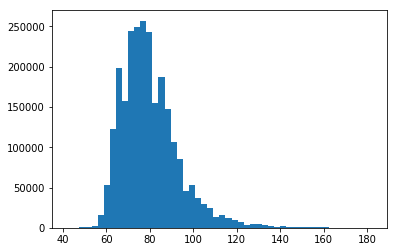

In [191]:
plt.hist(bpm,bins=50)

In [13]:
# Allows feeding a pandas dataframe containing non-numerical values directly into a pipeline - drops them
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

    # Definition of the CategoricalEncoder class, copied from PR #9151.
    # Just run this cell, or copy it to your code, do not try to understand it (yet).

    from sklearn.base import BaseEstimator, TransformerMixin
    from sklearn.utils import check_array
    from sklearn.preprocessing import LabelEncoder
    from scipy import sparse
# Present in SKlearn .20 dev0
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out